# Variational Autoencoders with Anime Faces Dataset

**Imports**

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

import os
import zipfile
import urllib.request
import random
from IPython import display

**Parameters**

In [3]:
BATCH_SIZE=2000
LATENT_DIM=512
IMAGE_SIZE=64

**Download and Prepare the Dataset**

In [4]:
try:
  os.mkdir('/tmp/anime')
except OSError:
  pass

data_url = "https://storage.googleapis.com/learning-datasets/Resources/anime-faces.zip"
data_file_name = "animefaces.zip"
download_dir = '/tmp/anime/'
urllib.request.urlretrieve(data_url, data_file_name)

zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [5]:
def get_dataset_slice_paths(image_dir):
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
  image = image / 255.0
  image = tf.reshape(image, shape=(IMAGE_SIZE, IMAGE_SIZE, 3,))

  return image

In [6]:
paths = get_dataset_slice_paths("/tmp/anime/images/")

random.shuffle(paths)

paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)
training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

number of batches in the training set: 26
number of batches in the validation set: 7


(2000, 64, 64, 3)


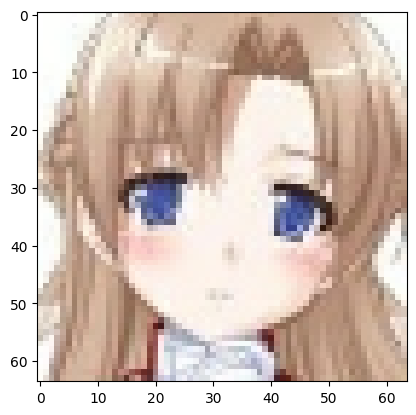

In [9]:
for images in training_dataset.take(1):
  print(images.shape)
  plt.imshow(tf.squeeze(images[0]));

**Display Utilities**

In [7]:
def display_faces(dataset, size=9):
  dataset = dataset.unbatch().take(size)
  n_cols = 3
  n_rows = size//n_cols + 1
  plt.figure(figsize=(5, 5))
  i = 0
  for image in dataset:
    i += 1
    disp_img = np.reshape(image, (64,64,3))
    plt.subplot(n_rows, n_cols, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp_img)


def display_one_row(disp_images, offset, shape=(28, 28)):
  for idx, image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    image = np.reshape(image, shape)
    plt.imshow(image)


def display_results(disp_input_images, disp_predicted):
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(IMAGE_SIZE,IMAGE_SIZE,3))
  display_one_row(disp_predicted, 20, shape=(IMAGE_SIZE,IMAGE_SIZE,3))


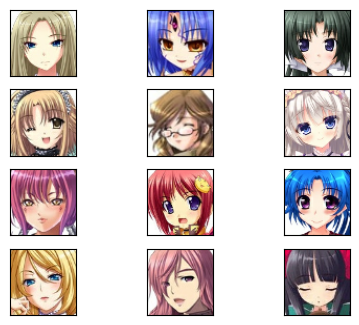

In [11]:
display_faces(validation_dataset, size=12)

**Build the Model**

The "Sampling" class will be created. This will be a custom Keras layer that will provide the Gaussian noise input along with the mean (mu) and standard deviation (sigma) of the encoder output. In practice, the output of this layer is given by the equation:

$$z = \mu + e^{0.5\sigma} * \epsilon $$

where $\mu$ = mean, $\sigma$ = standard deviation and $\epsilon$ = random sample

In [8]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    z = mu+tf.exp(0.5*sigma)*epsilon
    return  z

**Encoder Model**

In [52]:
tf.keras.backend.clear_session()

In [53]:
def encoder_layers(inputs, latent_dim):

  encoder=tf.keras.layers.Conv2D(32, (3,3), strides=2, padding="same", activation="relu", name="encoder_conv_1")(inputs)
  encoder=tf.keras.layers.BatchNormalization(name="encoder_batch_norm_1")(encoder)
  encoder=tf.keras.layers.Conv2D(64, (3,3), strides=2, padding="same", activation="relu", name="encoder_conv_2")(encoder)
  encoder=tf.keras.layers.BatchNormalization(name="encoder_batch_norm_2")(encoder)
  encoder=tf.keras.layers.Conv2D(128, (3,3), strides=2, padding="same", activation="relu", name="encoder_conv_3")(encoder)
  encoder_bn3=tf.keras.layers.BatchNormalization(name="encoder_batch_norm_3")(encoder)

  encoder=tf.keras.layers.Flatten(name="encoder_flatten")(encoder_bn3)
  encoder=tf.keras.layers.Dense(1024, activation="relu", name="encoder_dense")(encoder)
  encoder=tf.keras.layers.BatchNormalization(name="encoder_batch_norm_4")(encoder)

  mu=tf.keras.layers.Dense(latent_dim, name="encoder_mu")(encoder)
  sigma=tf.keras.layers.Dense(latent_dim, name="encoder_sigma")(encoder)

  return mu, sigma, encoder_bn3.shape

In [54]:
def encoder_model(latent_dim, input_shape):

  inputs = tf.keras.Input(shape=input_shape)
  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim)
  z = Sampling()((mu, sigma))
  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])
  model.summary()
  return model, conv_shape

**Decoder Model**

In [55]:
def decoder_layers(inputs, conv_shape):

  decoder=tf.keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu", name="decoder_dense1")(inputs)
  decoder=tf.keras.layers.BatchNormalization(name="decoder_batch_norm_1")(decoder)
  decoder=tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), name="decoder_reshape")(decoder)

  decoder=tf.keras.layers.Conv2DTranspose(128, (3,3), strides=2, padding="same", activation="relu", name="decoder_conv_trans_1")(decoder)
  decoder=tf.keras.layers.BatchNormalization(name="decoder_batch_norm_2")(decoder)
  decoder=tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, padding="same", activation="relu", name="decoder_conv_trans_2")(decoder)
  decoder=tf.keras.layers.BatchNormalization(name="decoder_batch_norm_3")(decoder)
  decoder=tf.keras.layers.Conv2DTranspose(32, (3,3), strides=2, padding="same", activation="relu", name="decoder_conv_trans_3")(decoder)
  decoder=tf.keras.layers.BatchNormalization(name="decoder_batch_norm_4")(decoder)
  decoder=tf.keras.layers.Conv2DTranspose(3, (3,3), strides=1, padding="same", activation="sigmoid", name="decoder_conv_trans_4")(decoder)

  return decoder

In [56]:
def decoder_model(latent_dim, conv_shape):

  inputs = tf.keras.Input(shape=(latent_dim, ))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  model.summary()
  return model

**Kullback–Leibler Divergence**


In [57]:
def kl_reconstruction_loss(mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

In [58]:
def vae_model(encoder, decoder, input_shape):

  inputs=tf.keras.Input(shape=input_shape)
  mu, sigma, z = encoder(inputs)
  reconstructed=decoder(z)
  model=tf.keras.Model(inputs=inputs, outputs=reconstructed)

  loss=kl_reconstruction_loss(mu, sigma)
  model.add_loss(loss)
  
  return model

In [59]:
def get_models(input_shape, latent_dim):
  encoder, conv_shape = encoder_model(latent_dim, input_shape)
  decoder=decoder_model(latent_dim, conv_shape)
  vae=vae_model(encoder, decoder, input_shape)
  return encoder, decoder, vae

In [60]:
encoder, decoder, vae = get_models(input_shape=(64,64,3,), latent_dim=LATENT_DIM)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 encoder_batch_norm_1 (BatchNor  (None, 32, 32, 32)  128         ['encoder_conv_1[0][0]']         
 malization)                                                                                      
                                                                                                  
 encoder_conv_2 (Conv2D)        (None, 16, 16, 64)   18496       ['encoder_batch_norm_1[0][0]'

In [22]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 model (Functional)             [(None, 512),        9537472     ['input_3[0][0]']                
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 3)    4476867     ['model[0][2]']                  
                                                                                            

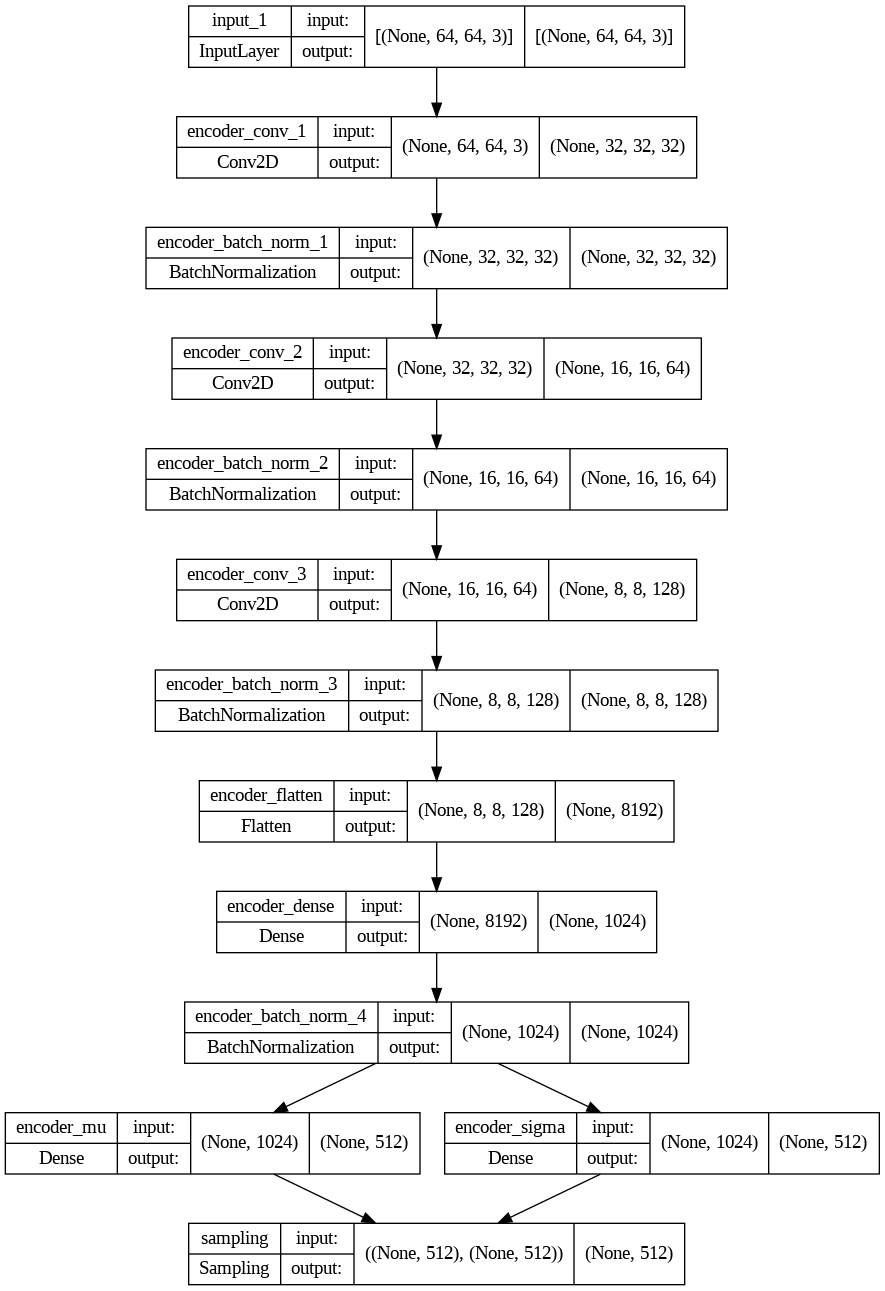

In [23]:
tf.keras.utils.plot_model(encoder, show_shapes=True, show_layer_names=True)

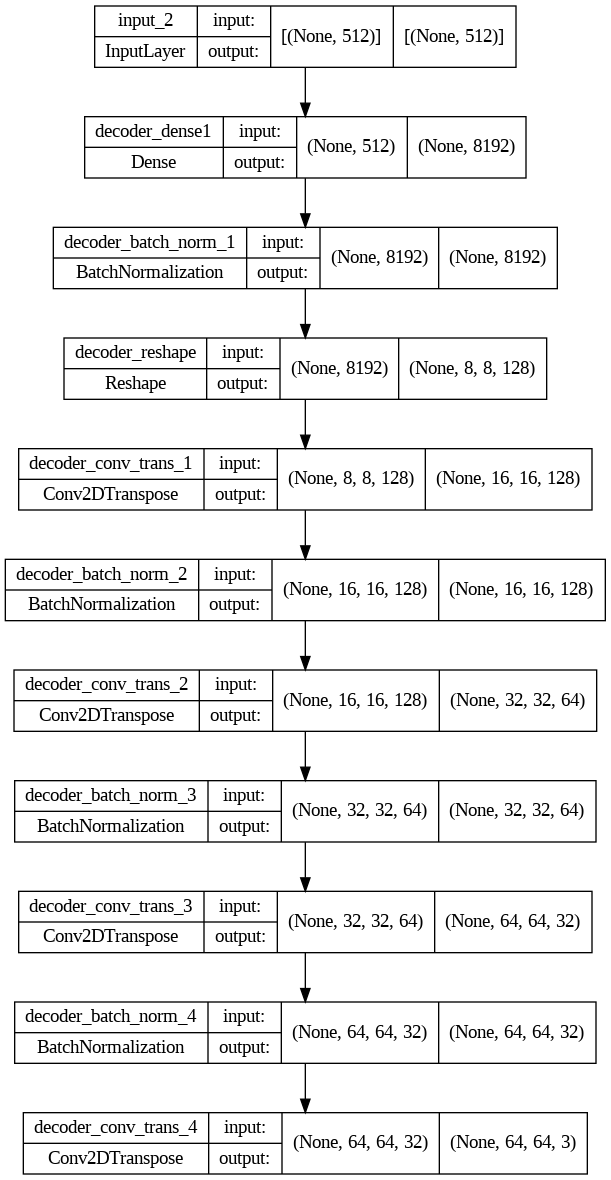

In [24]:
tf.keras.utils.plot_model(decoder, show_shapes=True, show_layer_names=True)

**Train the Model**


In [61]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
loss_metric = tf.keras.metrics.Mean()
mse_loss = tf.keras.losses.MeanSquaredError()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [62]:
def generate_and_save_images(model, epoch, step, test_input):
  predictions = model.predict(test_input)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      img = predictions[i, :, :, :] * 255
      img = img.astype('int32')
      plt.imshow(img)
      plt.axis('off')

  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

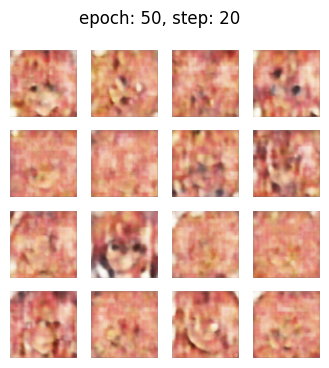

Epoch: 50 step: 20 mean loss = 298.2154
Mean loss is below 300! Stopping training.


In [63]:
epochs = 100
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(1, epochs+1):
  print('Start of epoch %d' % (epoch,))

  for step, x_batch_train in enumerate(training_dataset, 1):
    with tf.GradientTape() as tape:
      reconstructed = vae(x_batch_train)
      flattened_inputs=tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs=tf.reshape(reconstructed, shape=[-1])
      loss = mse_loss(flattened_inputs, flattened_outputs) * 64*64*3

      loss += sum(vae.losses)


    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    loss_metric(loss)

    if step % 10 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))

  if loss_metric.result().numpy()<300:
    print("Mean loss is below 300! Stopping training.")
    break

**Plot Reconstructed Images**


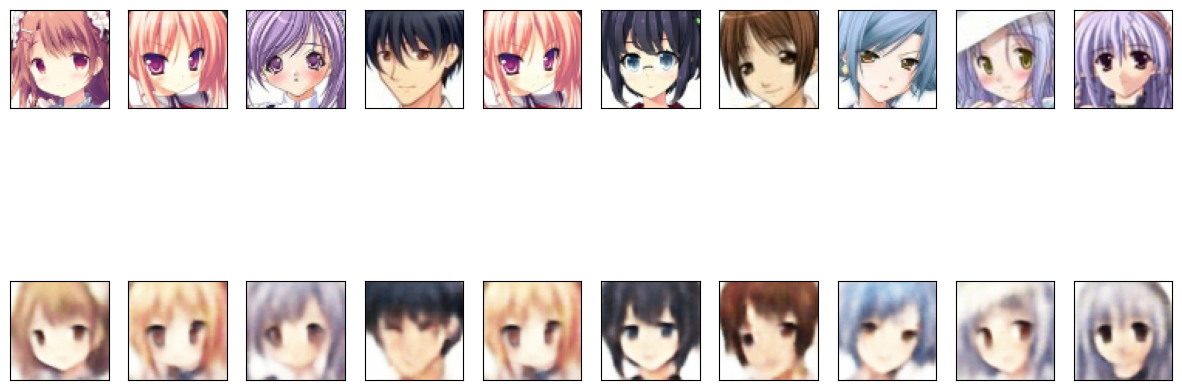

In [64]:
test_dataset = validation_dataset.take(1)
output_samples = []

for input_image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(64, size=10)

vae_predicted = vae.predict(test_dataset)
display_results(output_samples[idxs], vae_predicted[idxs])

**Plot Generatedd Images**


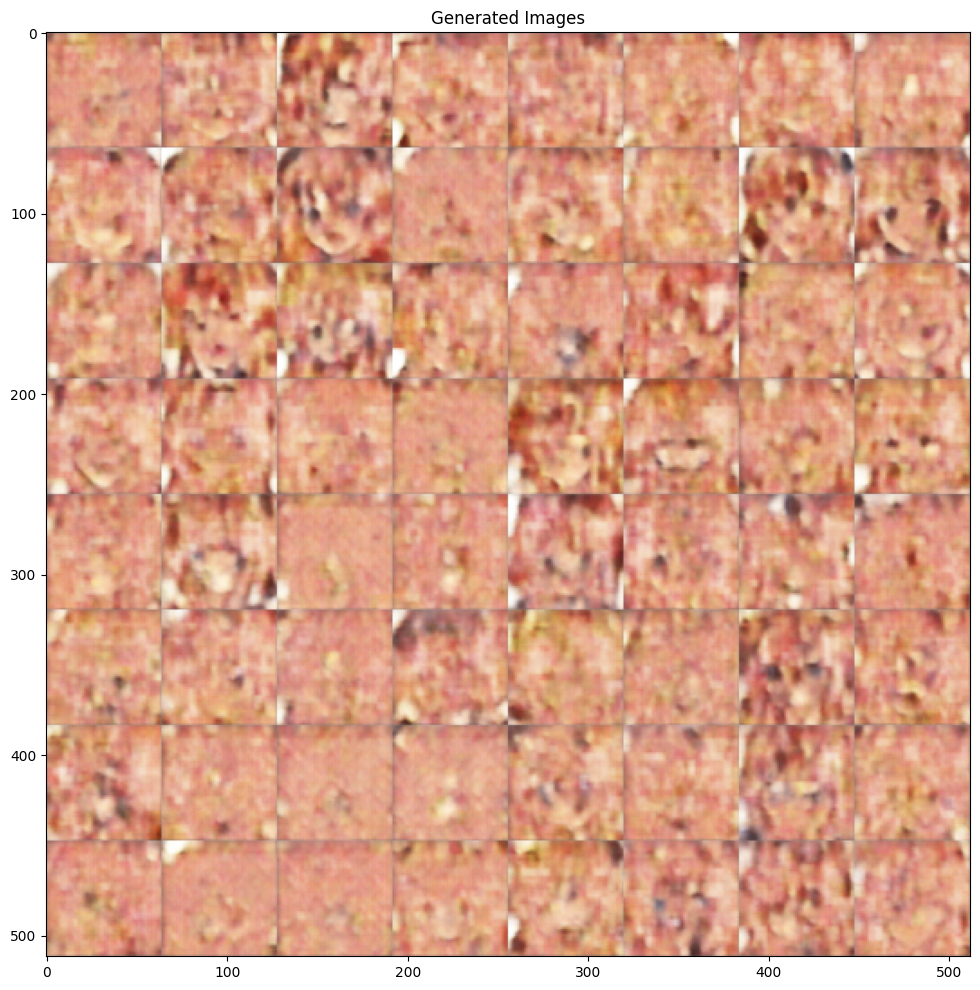

In [65]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*64, cols*64, 3))
    for row in range(rows):
        for col in range(cols):
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(12,12))
    plt.imshow(grid)
    plt.title(title)
    plt.show()

test_vector_for_generation = tf.random.normal(shape=[64, LATENT_DIM])

predictions= decoder.predict(test_vector_for_generation)

plot_images(8,8,predictions,'Generated Images')